# 1. Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from datetime import datetime
from pylab import rcParams
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import scipy.stats
import pylab

import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.stattools import adfuller,grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.api import VAR

from arch import arch_model

from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf,month_plot,quarter_plot
from statsmodels.tools.eval_measures import mse,rmse,meanabs

from pmdarima import auto_arima

# 2. Uploading Data

In [2]:
raw_data = pd.read_csv("rangedata_commodities_since1877.csv")
raw_data.head()

,Date,Range_W_F1,Range_W_F2,Range_C_F1,Range_C_F2,Range_O_F1,Range_O_F2
0,03-01-1877,0.010184,0.006173,0.004484,0.004065,0.008683,0.008487
1,04-01-1877,0.004713,0.006202,0.004494,0.002035,0.008608,NaN
2,05-01-1877,0.005527,0.004677,0.002250,0.002039,0.008608,0.002829
3,06-01-1877,0.007905,0.007800,0.006749,0.002035,0.011461,NaN
4,08-01-1877,0.010963,0.012365,0.013363,0.006091,0.002829,NaN


In [3]:
raw_data.Date[-1:]

39636    29-12-2017
Name: Date, dtype: object

# 3. Defining Data

##### Commodity Prices: Range 1877-2017
##### Commodities: Wheat, Corn, and Oats

This dataset contains over 140 years of historical commodity price ranges for wheat, corn, and oats futures contracts.

As Range_W_F2 means "Highest Price of Wheat Futures Contract", I will use F2 columns to analyze the time series.

Since the data covers 140 years, the data will be analyzed over monthly average prices.

# 4. Data Preprocessing

In [4]:
df = raw_data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39637 entries, 0 to 39636
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        39637 non-null  object 
 1   Range_W_F1  37121 non-null  float64
 2   Range_W_F2  37344 non-null  float64
 3   Range_C_F1  36597 non-null  float64
 4   Range_C_F2  37891 non-null  float64
 5   Range_O_F1  35785 non-null  float64
 6   Range_O_F2  37149 non-null  float64
dtypes: float64(6), object(1)
memory usage: 2.1+ MB


In [5]:
df.isnull().sum()

Date             0
Range_W_F1    2516
Range_W_F2    2293
Range_C_F1    3040
Range_C_F2    1746
Range_O_F1    3852
Range_O_F2    2488
dtype: int64

Datatypes appear to be correct except the date field. Since there are empty values in the data, it is necessary to deal with missing values first. Then, the date column will be examined.

##### Handling With Missing Values:

Since the data set is a time series, I found it correct to fill with the previous day value instead of deleting the blank values or filling them with values such as mean or median.

In [6]:
df = df.fillna(method = "ffill")  
df.isnull().sum()

Date          0
Range_W_F1    0
Range_W_F2    0
Range_C_F1    0
Range_C_F2    0
Range_O_F1    0
Range_O_F2    0
dtype: int64

##### Simplify the dataset and deal with the date:

In [7]:
df = df[["Date","Range_W_F2","Range_C_F2","Range_O_F2"]]
df.columns = ["Date","Wheat","Corn","Oats"]
df.Date = pd.to_datetime(df.Date,dayfirst = True) 
df.set_index("Date", inplace=True)
df

,Wheat,Corn,Oats
Date,,,
1877-01-03,0.006173,0.004065,0.008487
1877-01-04,0.006202,0.002035,0.008487
1877-01-05,0.004677,0.002039,0.002829
1877-01-06,0.007800,0.002035,0.002829
1877-01-08,0.012365,0.006091,0.002829
...,...,...,...
2017-12-25,0.009684,0.005559,0.010050
2017-12-26,0.012593,0.006244,0.010071
2017-12-27,0.016567,0.007610,0.007025


##### Creating the final version of the dataset with monthly average price information:

In [8]:
df = df.resample(rule='M').mean()
df

,Wheat,Corn,Oats
Date,,,
1877-01-31,0.010291,0.008333,0.004466
1877-02-28,0.011007,0.010575,0.006840
1877-03-31,0.008941,0.010240,0.007044
1877-04-30,0.023222,0.026919,0.012683
1877-05-31,0.027315,0.034813,0.005033
...,...,...,...
2017-08-31,0.022669,0.016458,0.030710
2017-09-30,0.019878,0.015189,0.021739
2017-10-31,0.016533,0.011207,0.019785


In [9]:
# Checking the index type and freq info

df.index

DatetimeIndex(['1877-01-31', '1877-02-28', '1877-03-31', '1877-04-30',
               '1877-05-31', '1877-06-30', '1877-07-31', '1877-08-31',
               '1877-09-30', '1877-10-31',
               ...
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=1692, freq='M')

# 5. Plotting Data

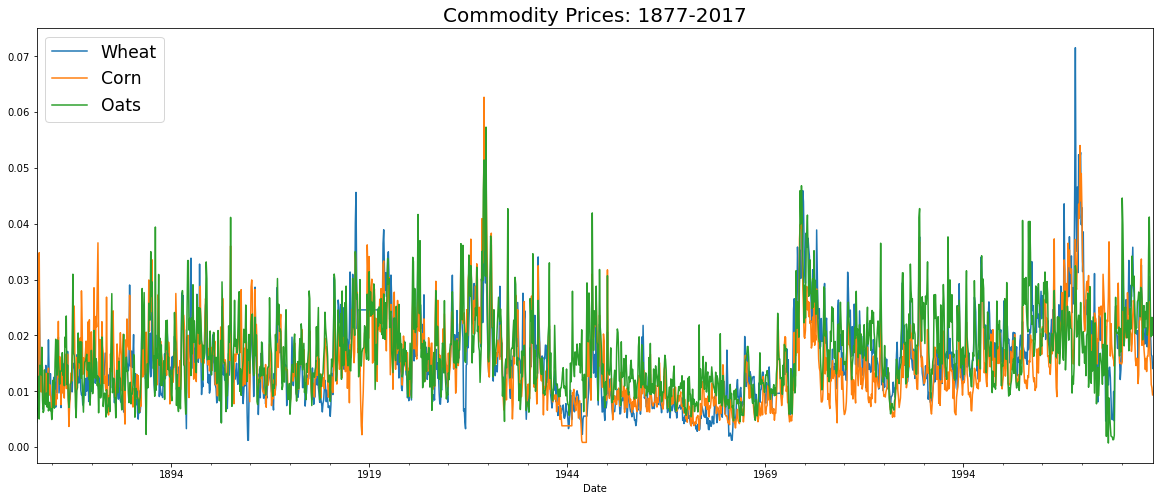

In [17]:
df.plot(figsize=(20,8))
plt.title("Commodity Prices: 1877-2017",fontsize=20)
plt.legend(loc="upper left",fontsize="xx-large")
plt.show()

At first glance, I can say that all 3 time series look stationary. Although there are outliers from time to time, there are generally decreases and increases in certain price ranges in line with the parameters of the market. There is no specific trend. For a more detailed analysis, I will observe the commodity items one by one.

#### WHEAT:

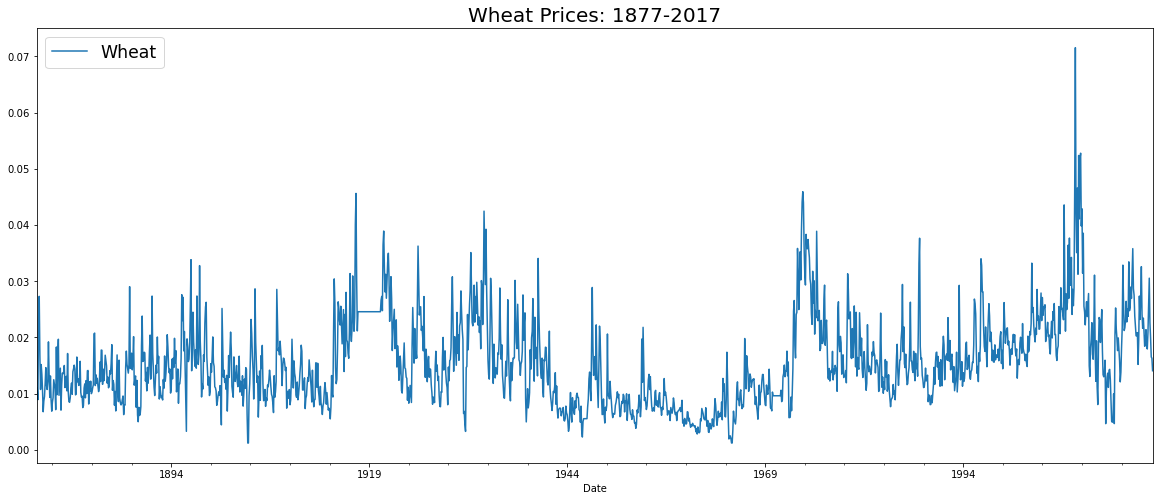

In [28]:
df.Wheat.plot(figsize=(20,8))
plt.title("Wheat Prices: 1877-2017",fontsize=20)
plt.legend(loc="upper left",fontsize="xx-large")
plt.show()

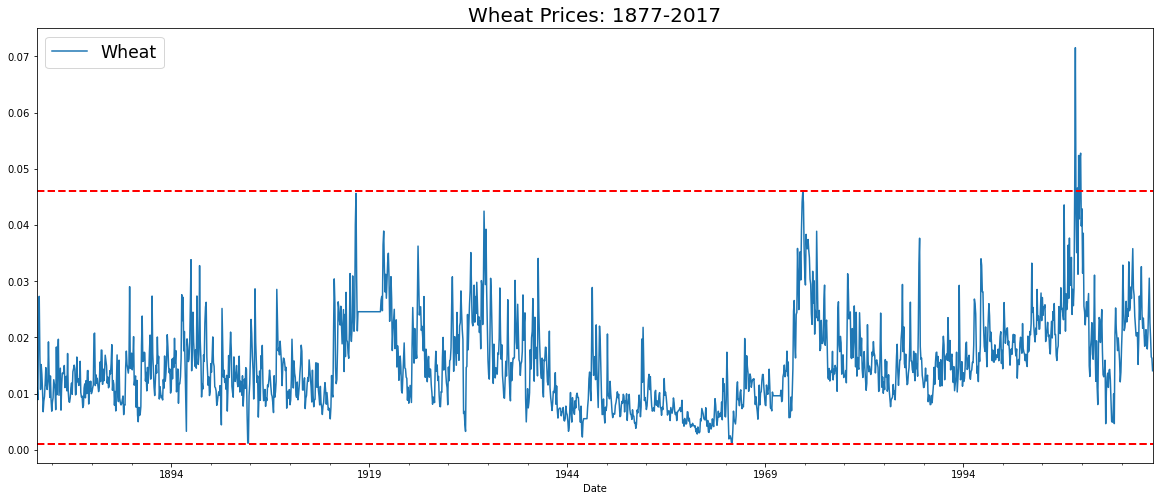

In [34]:
df.Wheat.plot(figsize=(20,8))
plt.title("Wheat Prices: 1877-2017",fontsize=20)
plt.axhline(y=0.046, color='r', linestyle='--',lw=2)
plt.axhline(y=0.001, color='r', linestyle='--',lw=2)
plt.legend(loc="upper left",fontsize="xx-large")
plt.show()

As can be seen, except for the violation occured at 2008 March, we can say this series is stationary.

The related anomaly points to the food crisis in 2008.

In [35]:
df[df.Wheat == max(df.Wheat)].index

DatetimeIndex(['2008-03-31'], dtype='datetime64[ns]', name='Date', freq='M')

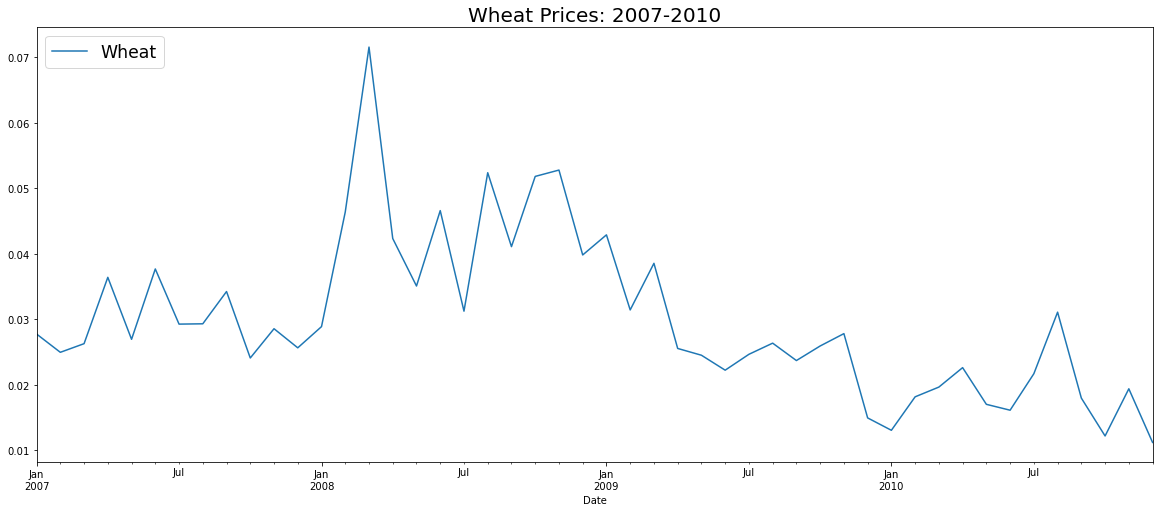

In [38]:
# A closer look at the relevant date:

df.Wheat.loc["2007-01-01":"2010-12-31"].plot(figsize=(20,8))
plt.title("Wheat Prices: 2007-2010",fontsize=20)
plt.legend(loc="upper left",fontsize="xx-large")
plt.show()

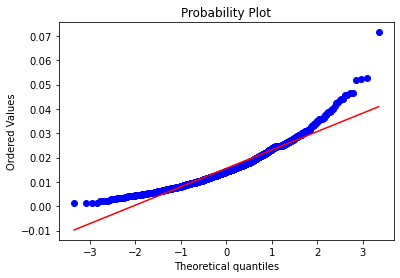

In [47]:
scipy.stats.probplot(df.Wheat,plot=pylab)
pylab.show()

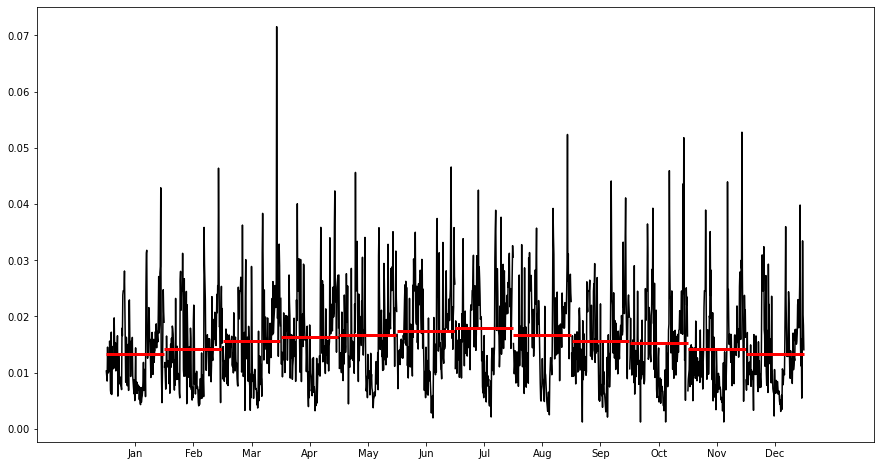

In [52]:
rcParams["figure.figsize"] = 15,8
month_plot(df.Wheat);

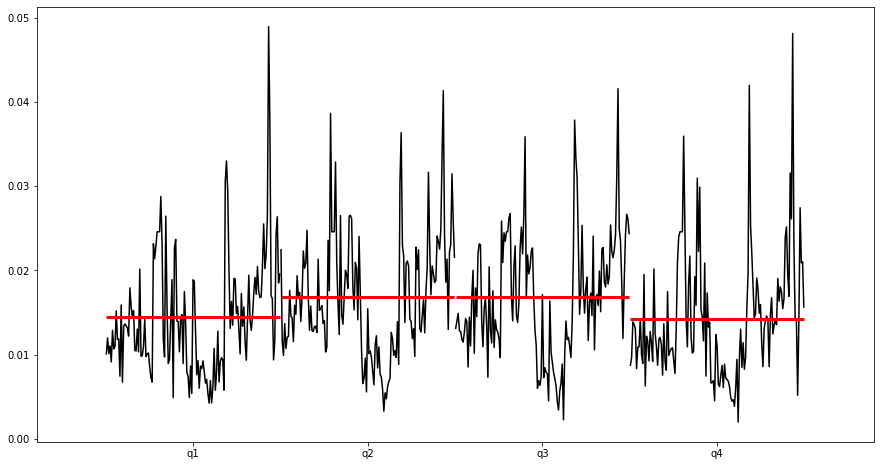

In [53]:
df_q = df.Wheat.resample(rule="Q").mean()
quarter_plot(df_q);

#### CORN:

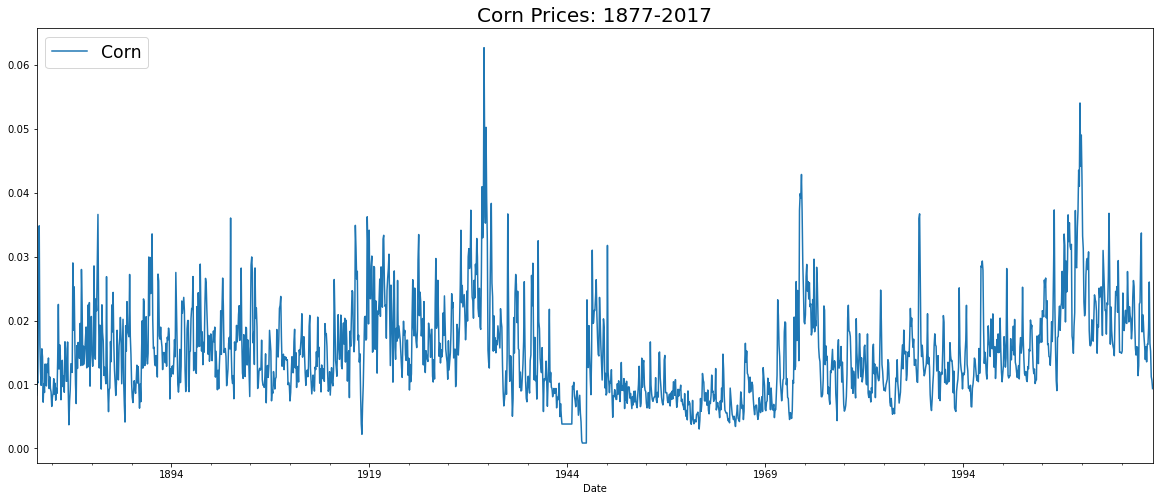

In [54]:
df.Corn.plot(figsize=(20,8))
plt.title("Corn Prices: 1877-2017",fontsize=20)
plt.legend(loc="upper left",fontsize="xx-large")
plt.show()

Corn prices also seem stationary.

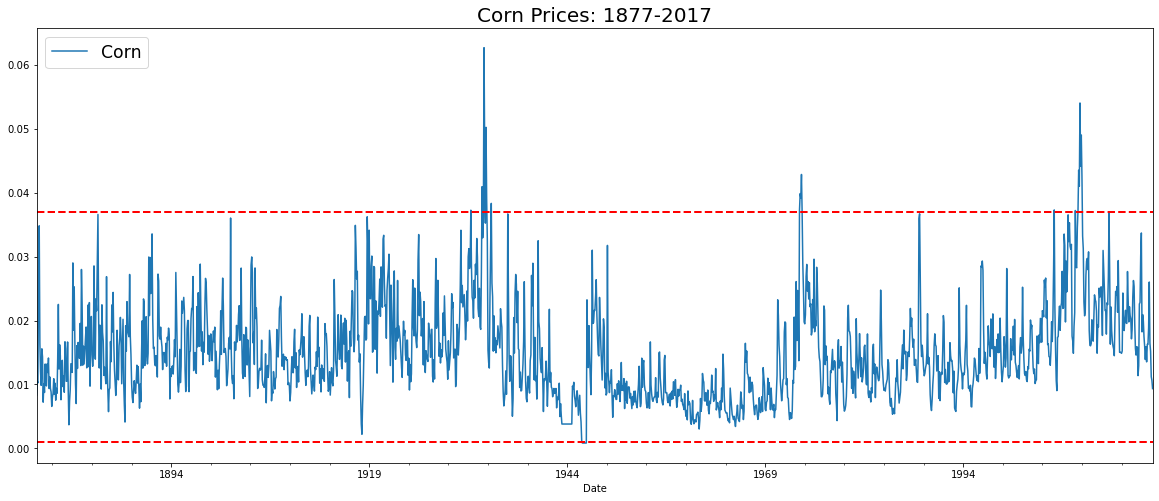

In [56]:
df.Corn.plot(figsize=(20,8))
plt.title("Corn Prices: 1877-2017",fontsize=20)
plt.axhline(y=0.037, color='r', linestyle='--',lw=2)
plt.axhline(y=0.001, color='r', linestyle='--',lw=2)
plt.legend(loc="upper left",fontsize="xx-large")
plt.show()

As corn prices are examined, there are 3 violations above price 0.037

In [57]:
df.Corn[df.Corn>0.037]

Date
1931-11-30    0.037255
1933-04-30    0.040927
1933-07-31    0.062668
1933-08-31    0.046483
1933-10-31    0.050214
1933-11-30    0.038975
1934-06-30    0.038323
1973-05-31    0.037232
1973-06-30    0.039848
1973-07-31    0.039180
1973-08-31    0.042843
2005-07-31    0.037296
2008-03-31    0.037206
2008-07-31    0.037140
2008-08-31    0.043514
2008-09-30    0.040996
2008-10-31    0.054023
2008-11-30    0.044103
2008-12-31    0.049018
2009-01-31    0.042539
Name: Corn, dtype: float64

- The Agricultural Adjustment Act (AAA) was a federal law passed in 1933.
- In 1973, the Food Price Inflation affected corn prices.
- Lastly, there was a food crisis in 2008.

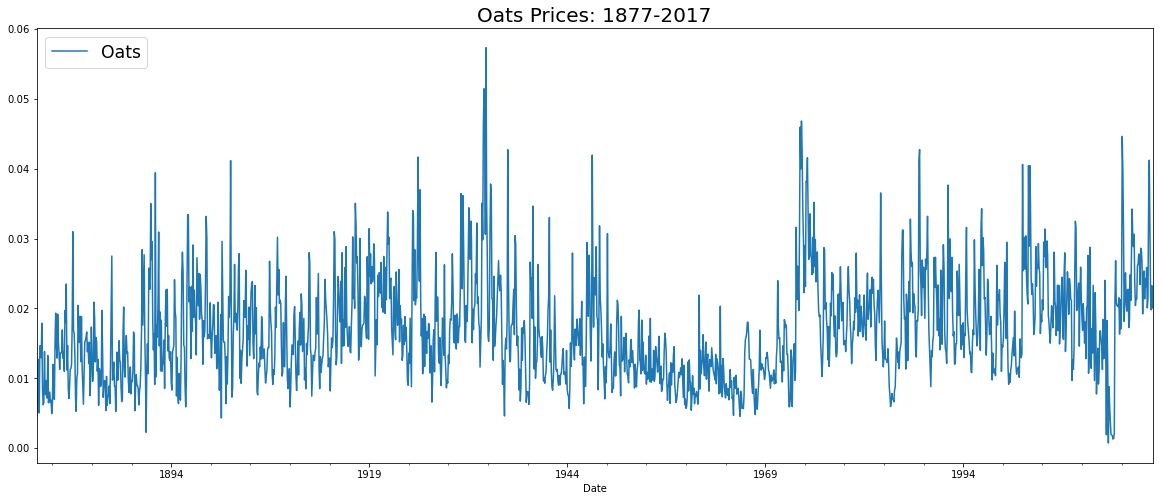

In [58]:
df.Oats.plot(figsize=(20,8))
plt.title("Oats Prices: 1877-2017",fontsize=20)
plt.legend(loc="upper left",fontsize="xx-large")
plt.show()

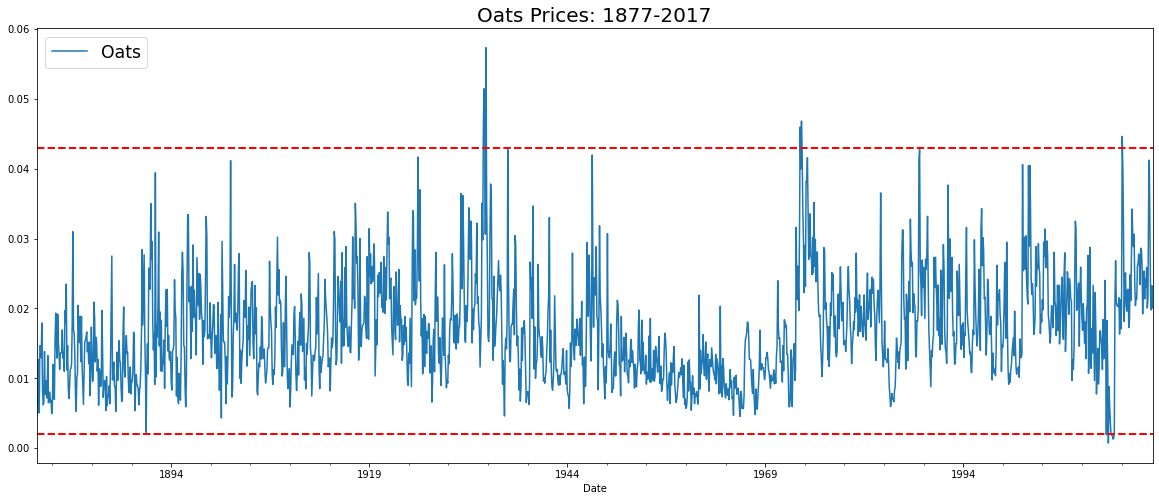

In [61]:
df.Oats.plot(figsize=(20,8))
plt.title("Oats Prices: 1877-2017",fontsize=20)
plt.axhline(y=0.043, color='r', linestyle='--',lw=2)
plt.axhline(y=0.002, color='r', linestyle='--',lw=2)
plt.legend(loc="upper left",fontsize="xx-large")
plt.show()

In [63]:
df.Oats[df.Oats>0.043]

Date
1933-06-30    0.046017
1933-07-31    0.051436
1933-08-31    0.048856
1933-10-31    0.057312
1973-06-30    0.045941
1973-08-31    0.046820
2014-02-28    0.044615
Name: Oats, dtype: float64

Oats prices also have anomalies for reasons similar to those in corn.

# 6. Seasonal Decompose

### Wheat:

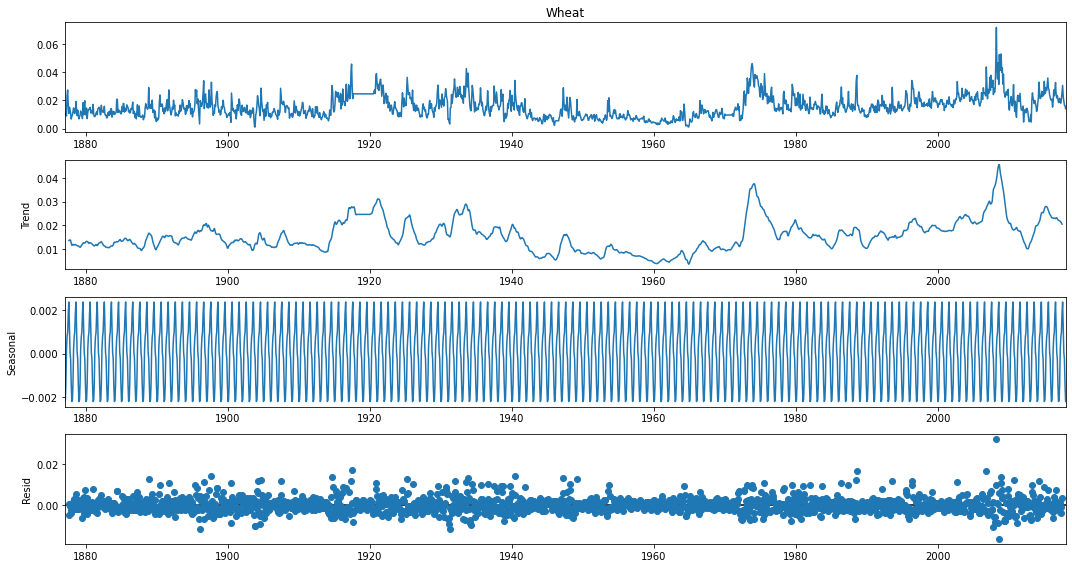

In [65]:
result = seasonal_decompose(df.Wheat,model="add")  
rcParams["figure.figsize"] = 15,8
result.plot();

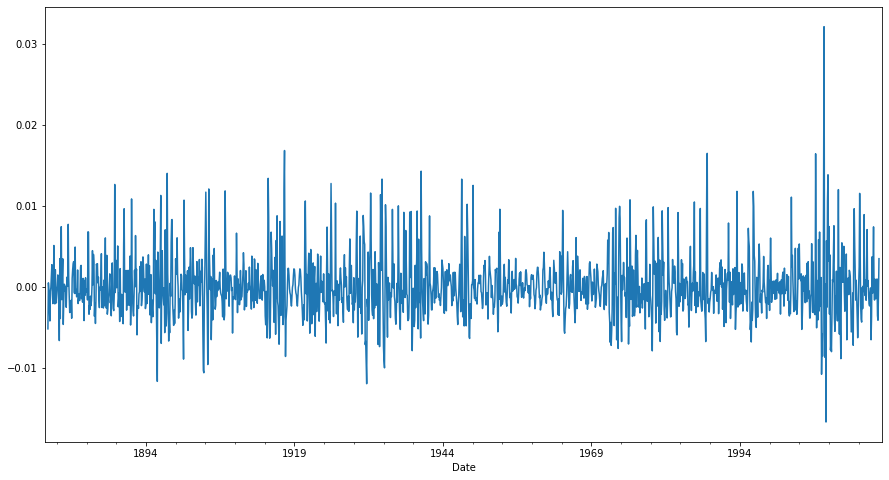

In [66]:
result.resid.plot();

### Corn:

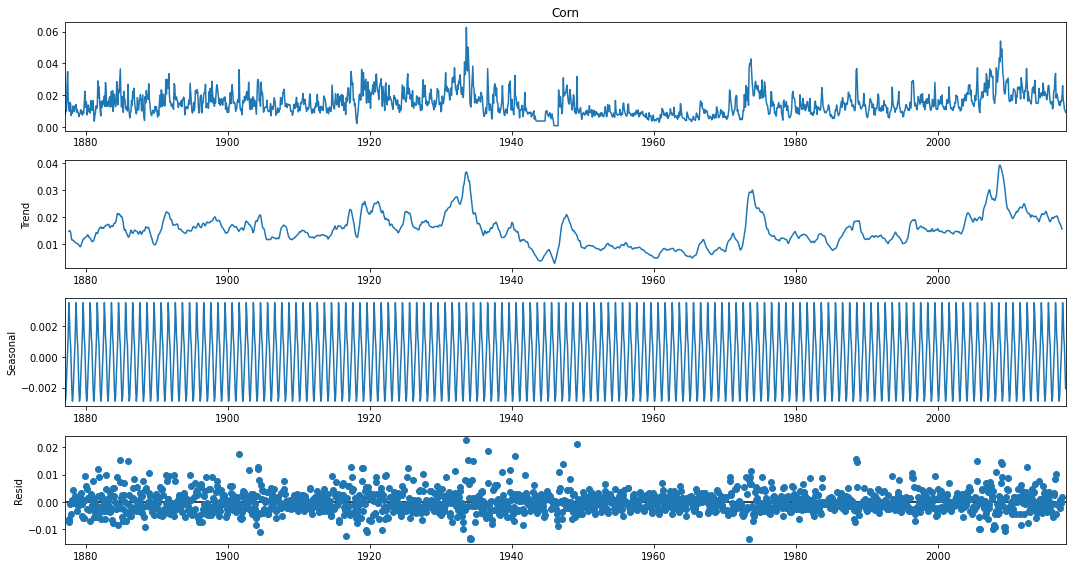

In [67]:
result = seasonal_decompose(df.Corn,model="add")  
rcParams["figure.figsize"] = 15,8
result.plot();

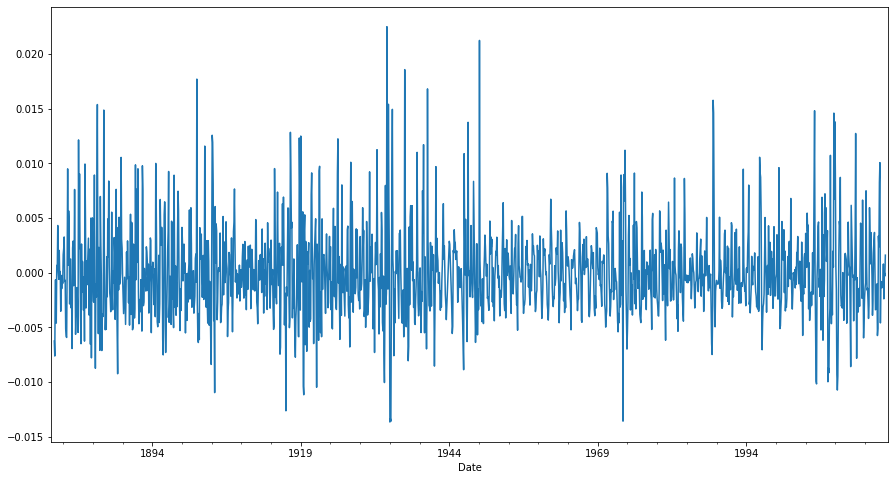

In [68]:
result.resid.plot();

### Oats:

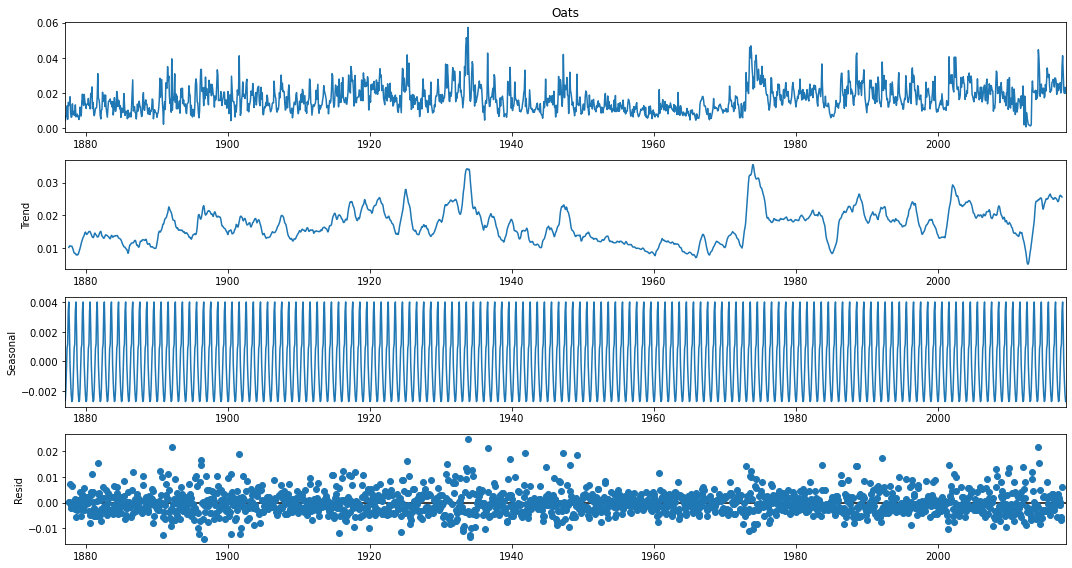

In [69]:
result = seasonal_decompose(df.Oats,model="add")  
rcParams["figure.figsize"] = 15,8
result.plot();

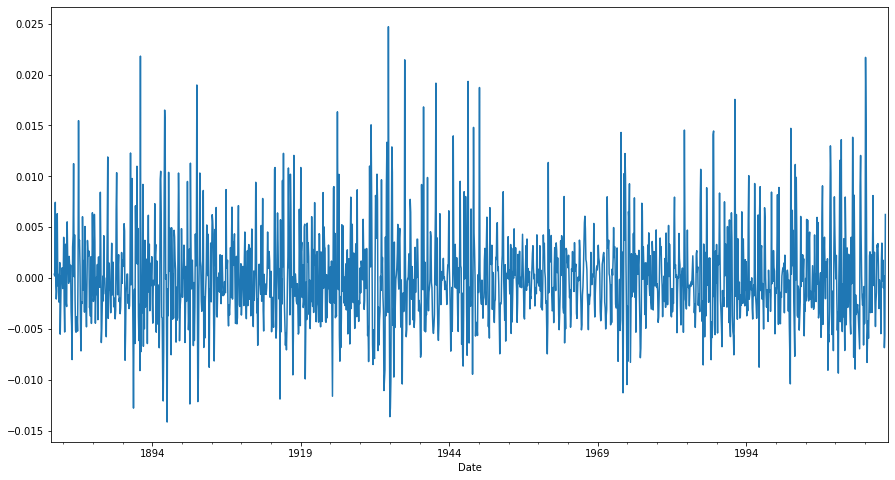

In [70]:
result.resid.plot();

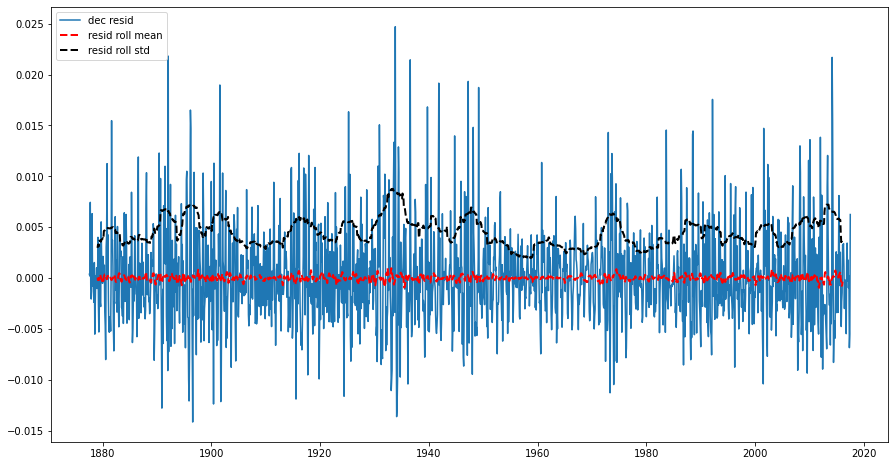

In [89]:
ar = result.resid
rolm = pd.Series.rolling(ar, window = 36, center = True).mean()
rolstd = pd.Series.rolling(ar, window = 36, center = True).std()
plt.plot(result.resid, label = 'dec resid')
plt.plot(rolm, label = 'resid roll mean', linestyle = '--',lw=2,c="r")
plt.plot(rolstd, label = 'resid roll std', linestyle = '--',lw=2,c="black")
plt.legend()
plt.show()

### The Hodrick-Prescott Filter

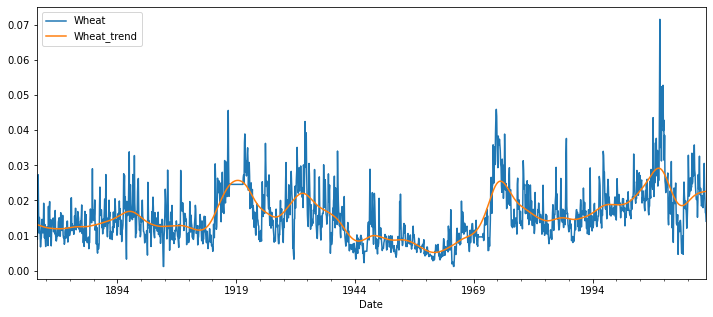

In [135]:
wheat_cycle, wheat_trend = hpfilter(df.Wheat,lamb=129600)
df.Wheat.plot(figsize=(12,5),legend=True)
wheat_trend.plot(legend=True);

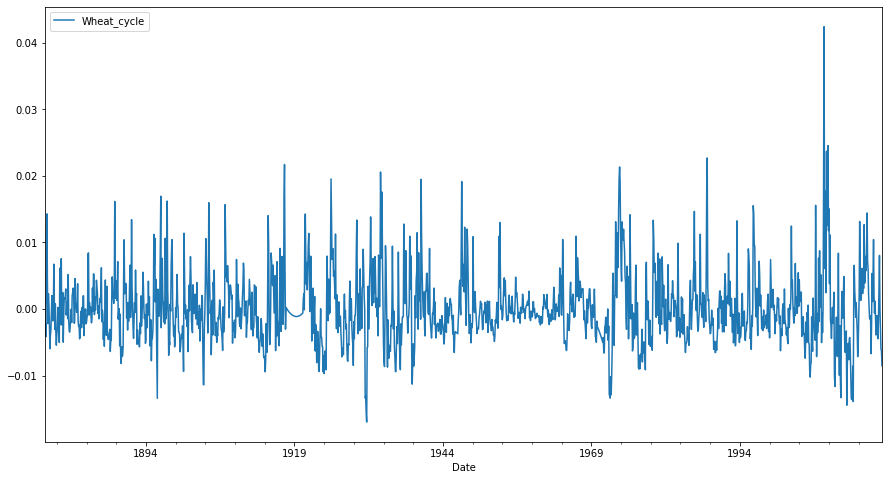

In [136]:
wheat_cycle.plot(legend=True);

 As seen in The Hodrick-Prescott Filter, there is no trend. However, there is some small amount
 of seasonality.   

# 7. Dickey-Fuller Test For Stationarity

In [71]:
def adf_test(series):

    print(f'Augmented Dickey-Fuller Test:')
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [72]:
adf_test(df.Wheat)

Augmented Dickey-Fuller Test:
ADF test statistic        -3.892552
p-value                    0.002090
# lags used               25.000000
# observations          1666.000000
critical value (1%)       -3.434281
critical value (5%)       -2.863276
critical value (10%)      -2.567694
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [73]:
adf_test(df.Corn)

Augmented Dickey-Fuller Test:
ADF test statistic        -3.647401
p-value                    0.004917
# lags used               25.000000
# observations          1666.000000
critical value (1%)       -3.434281
critical value (5%)       -2.863276
critical value (10%)      -2.567694
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [74]:
adf_test(df.Oats)

Augmented Dickey-Fuller Test:
ADF test statistic        -4.092585
p-value                    0.000996
# lags used               24.000000
# observations          1667.000000
critical value (1%)       -3.434279
critical value (5%)       -2.863275
critical value (10%)      -2.567694
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


# 8. ACF - PACF - LAG PLOT

### Wheat:

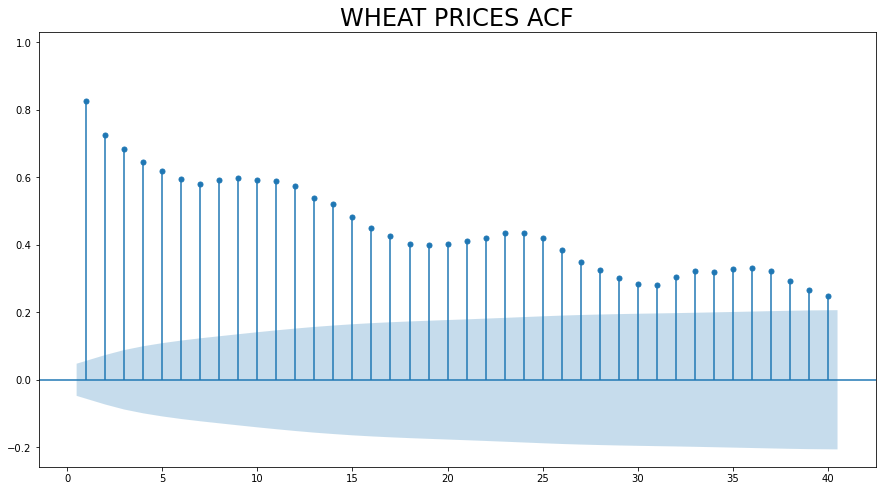

In [75]:
plot_acf(df.Wheat,lags=40,zero=False,auto_ylims=True)
plt.title("WHEAT PRICES ACF",size=24)
plt.show()

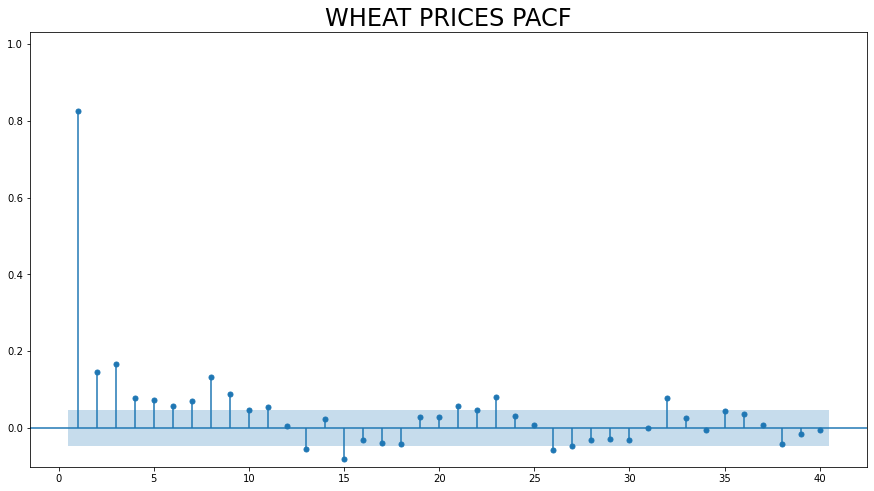

In [77]:
plot_pacf(df.Wheat,lags=40,zero=False,auto_ylims=True)
plt.title("WHEAT PRICES PACF",size=24)
plt.show()

### PACF sharp cutoff and ACF decays slowly ==> Stationary AR signature

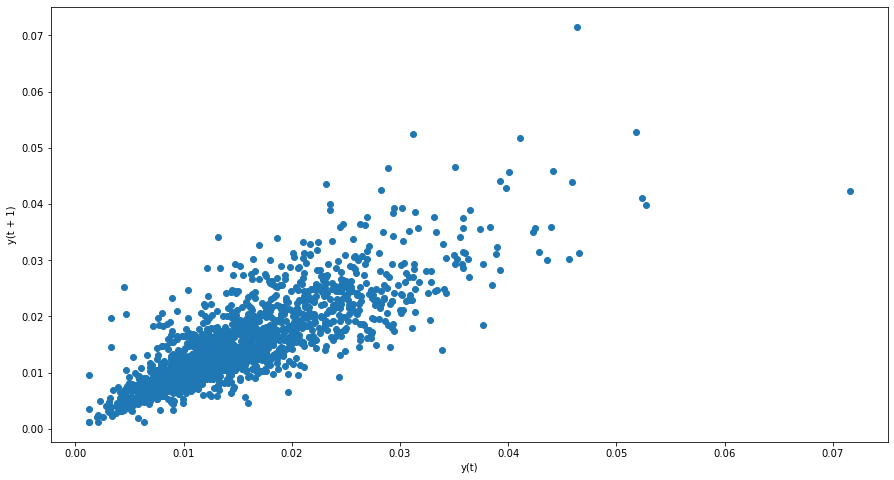

In [90]:
lag_plot(df.Wheat);

### Corn:

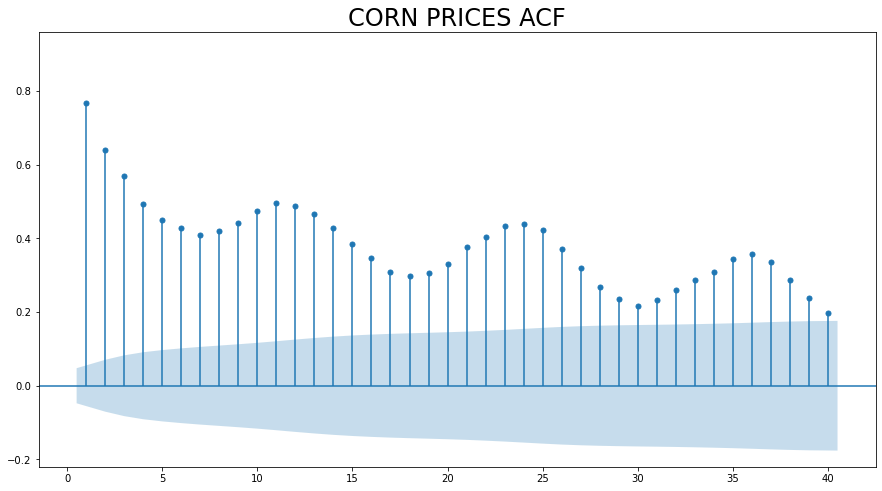

In [91]:
plot_acf(df.Corn,lags=40,zero=False,auto_ylims=True)
plt.title("CORN PRICES ACF",size=24)
plt.show()

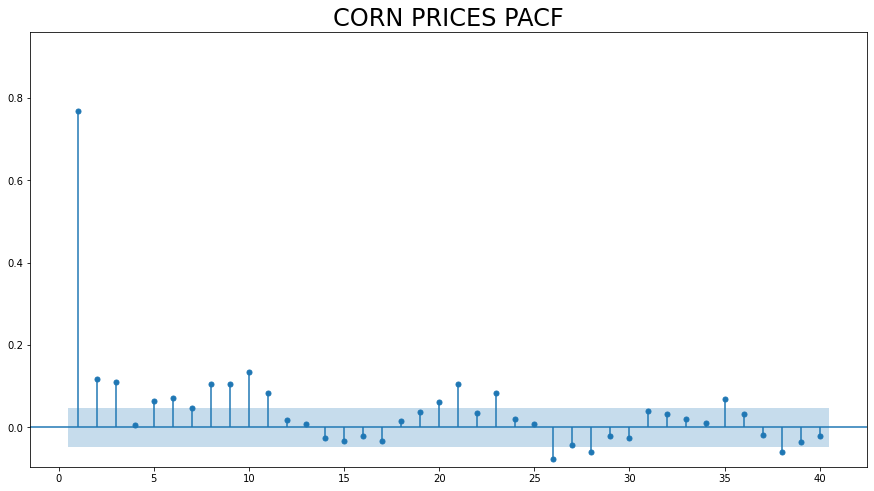

In [92]:
plot_pacf(df.Corn,lags=40,zero=False,auto_ylims=True)
plt.title("CORN PRICES PACF",size=24)
plt.show()

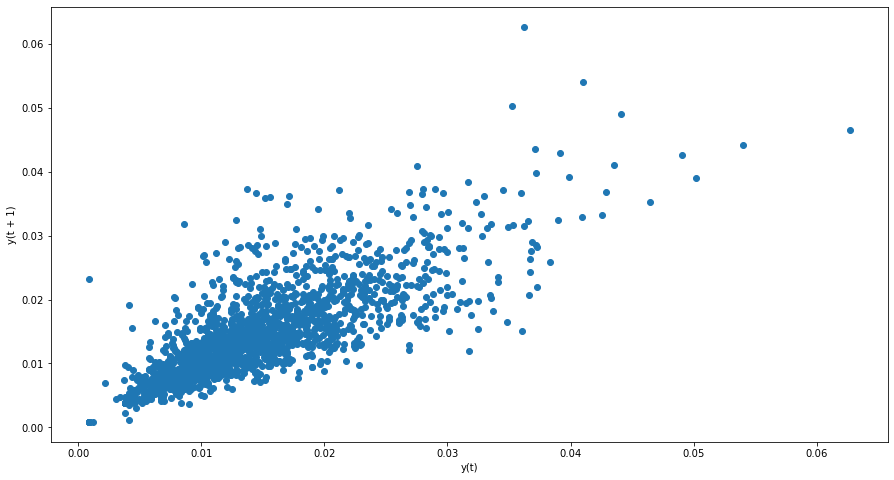

In [93]:
lag_plot(df.Corn);

### Oats:

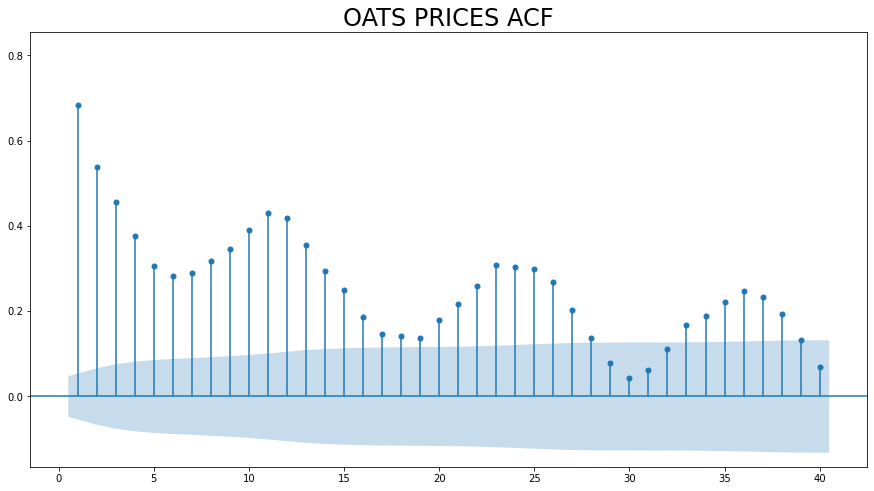

In [94]:
plot_acf(df.Oats,lags=40,zero=False,auto_ylims=True)
plt.title("OATS PRICES ACF",size=24)
plt.show()

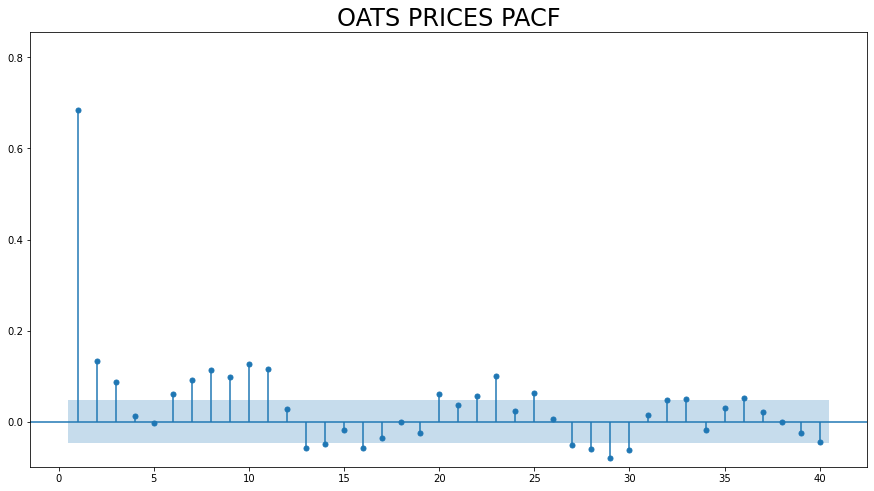

In [95]:
plot_pacf(df.Oats,lags=40,zero=False,auto_ylims=True)
plt.title("OATS PRICES PACF",size=24)
plt.show()

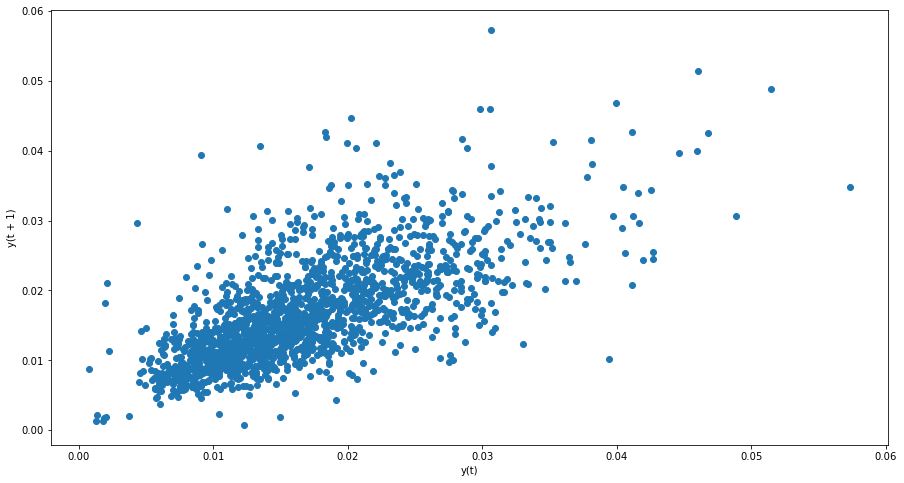

In [96]:
lag_plot(df.Oats);

# 9. Granger Causality Tests

In [98]:
grangercausalitytests(df[["Wheat","Corn"]],maxlag=5);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0159  , p=0.8996  , df_denom=1688, df_num=1
ssr based chi2 test:   chi2=0.0159  , p=0.8995  , df=1
likelihood ratio test: chi2=0.0159  , p=0.8995  , df=1
parameter F test:         F=0.0159  , p=0.8996  , df_denom=1688, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6327  , p=0.1957  , df_denom=1685, df_num=2
ssr based chi2 test:   chi2=3.2750  , p=0.1945  , df=2
likelihood ratio test: chi2=3.2719  , p=0.1948  , df=2
parameter F test:         F=1.6327  , p=0.1957  , df_denom=1685, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5033  , p=0.0577  , df_denom=1682, df_num=3
ssr based chi2 test:   chi2=7.5412  , p=0.0565  , df=3
likelihood ratio test: chi2=7.5244  , p=0.0569  , df=3
parameter F test:         F=2.5033  , p=0.0577  , df_denom=1682, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2703  , p=0.

In [99]:
grangercausalitytests(df[["Wheat","Oats"]],maxlag=5);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3919  , p=0.2383  , df_denom=1688, df_num=1
ssr based chi2 test:   chi2=1.3943  , p=0.2377  , df=1
likelihood ratio test: chi2=1.3938  , p=0.2378  , df=1
parameter F test:         F=1.3919  , p=0.2383  , df_denom=1688, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1999  , p=0.3015  , df_denom=1685, df_num=2
ssr based chi2 test:   chi2=2.4070  , p=0.3001  , df=2
likelihood ratio test: chi2=2.4053  , p=0.3004  , df=2
parameter F test:         F=1.1999  , p=0.3015  , df_denom=1685, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.2703  , p=0.0205  , df_denom=1682, df_num=3
ssr based chi2 test:   chi2=9.8516  , p=0.0199  , df=3
likelihood ratio test: chi2=9.8230  , p=0.0201  , df=3
parameter F test:         F=3.2703  , p=0.0205  , df_denom=1682, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.4763  , p=0.

In [100]:
grangercausalitytests(df[["Corn","Oats"]],maxlag=5);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8774  , p=0.0088  , df_denom=1688, df_num=1
ssr based chi2 test:   chi2=6.8897  , p=0.0087  , df=1
likelihood ratio test: chi2=6.8757  , p=0.0087  , df=1
parameter F test:         F=6.8774  , p=0.0088  , df_denom=1688, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.6536  , p=0.0097  , df_denom=1685, df_num=2
ssr based chi2 test:   chi2=9.3348  , p=0.0094  , df=2
likelihood ratio test: chi2=9.3091  , p=0.0095  , df=2
parameter F test:         F=4.6536  , p=0.0097  , df_denom=1685, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.8539  , p=0.0023  , df_denom=1682, df_num=3
ssr based chi2 test:   chi2=14.6224 , p=0.0022  , df=3
likelihood ratio test: chi2=14.5594 , p=0.0022  , df=3
parameter F test:         F=4.8539  , p=0.0023  , df_denom=1682, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.6925  , p=0.

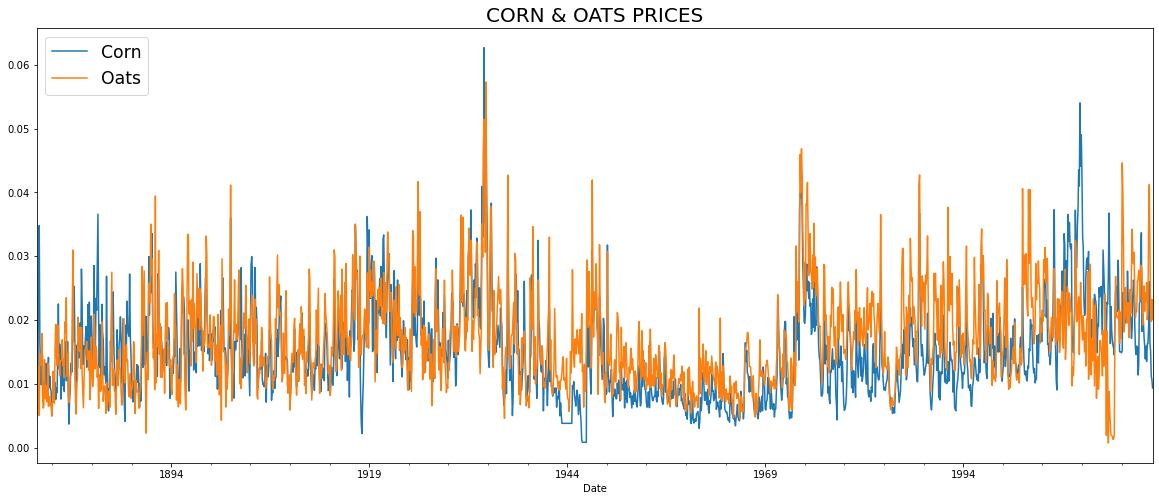

In [101]:
df[["Corn","Oats"]].plot(figsize=(20,8))
plt.title("CORN & OATS PRICES",fontsize=20)
plt.legend(loc="upper left",fontsize="xx-large")
plt.show()

In [132]:
df.corr()

,Wheat,Corn,Oats
Wheat,1.000000,0.745136,0.664990
Corn,0.745136,1.000000,0.650392
Oats,0.664990,0.650392,1.000000


# 10. Increase the stationarity level

### Using diff function:

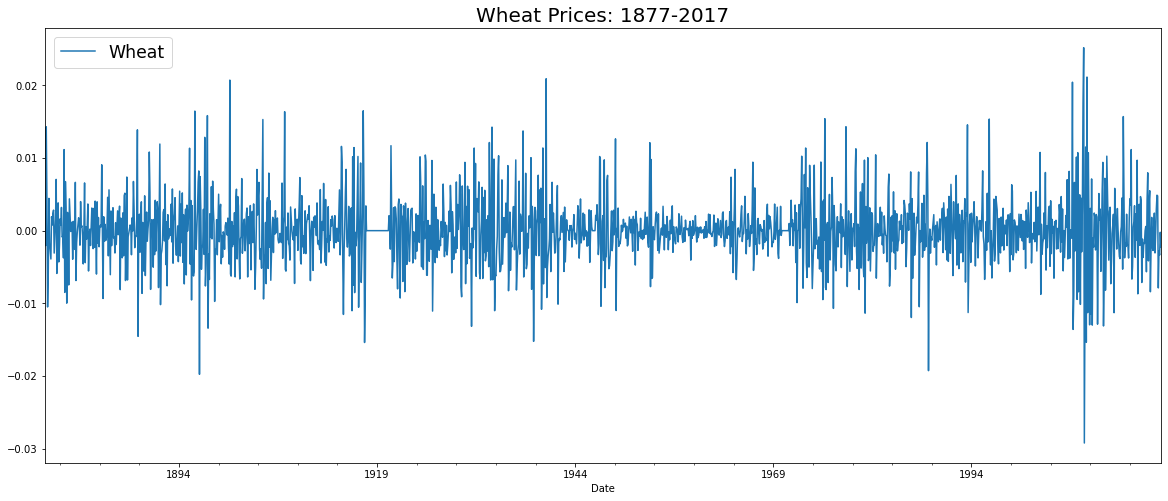

In [117]:
d_wheat = diff(df.Wheat,k_diff=1)

d_wheat.plot(figsize=(20,8))
plt.title("Wheat Prices: 1877-2017",fontsize=20)
plt.legend(loc="upper left",fontsize="xx-large")
plt.show()

### Remove Volatility:

In [118]:
annual_volatility = d_wheat.groupby(d_wheat.index.year).std()
annual_volatility

Date
1877    0.006493
1878    0.003851
1879    0.005908
1880    0.003730
1881    0.002893
          ...   
2013    0.005756
2014    0.005403
2015    0.004156
2016    0.004944
2017    0.003758
Name: Wheat, Length: 141, dtype: float64

In [119]:
wheat_annual_vol = d_wheat.index.map(lambda d: annual_volatility.loc[d.year])
d_wheat = d_wheat / wheat_annual_vol

Float64Index([ 0.006493018578982893,  0.006493018578982893,
               0.006493018578982893,  0.006493018578982893,
               0.006493018578982893,  0.006493018578982893,
               0.006493018578982893,  0.006493018578982893,
               0.006493018578982893,  0.006493018578982893,
              ...
              0.0037576099304988736, 0.0037576099304988736,
              0.0037576099304988736, 0.0037576099304988736,
              0.0037576099304988736, 0.0037576099304988736,
              0.0037576099304988736, 0.0037576099304988736,
              0.0037576099304988736, 0.0037576099304988736],
             dtype='float64', name='Date', length=1691)

In [125]:
d_wheat.dropna(inplace=True)

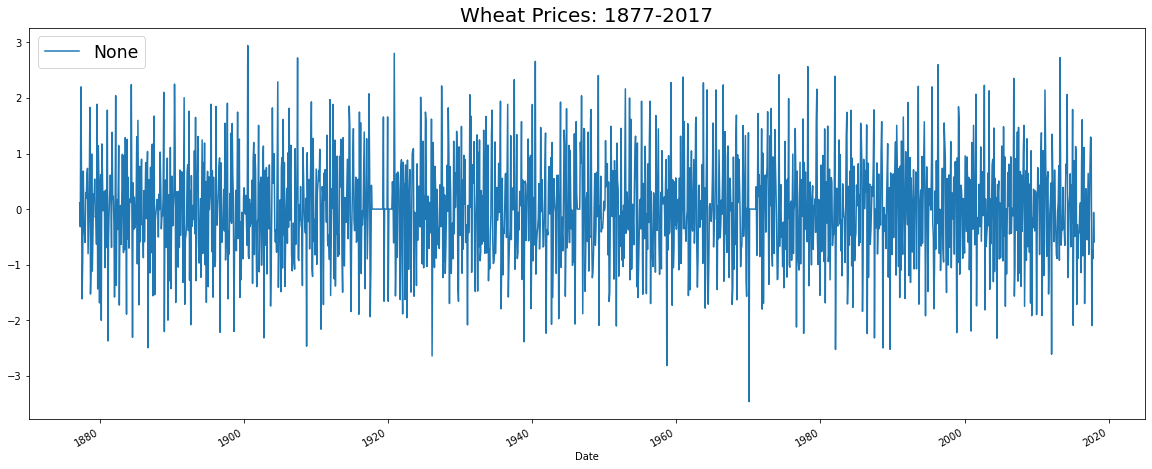

In [127]:
d_wheat.plot(figsize=(20,8))
plt.title("Wheat Prices: 1877-2017",fontsize=20)
plt.legend(loc="upper left",fontsize="xx-large")
plt.show()

### Checking Augmented Dickey-Fuller Test and ACF-PACF-LAGS PLOT

In [128]:
adf_test(d_wheat)

Augmented Dickey-Fuller Test:
ADF test statistic     -1.213445e+01
p-value                 1.706286e-22
# lags used             2.100000e+01
# observations          1.657000e+03
critical value (1%)    -3.434303e+00
critical value (5%)    -2.863286e+00
critical value (10%)   -2.567699e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


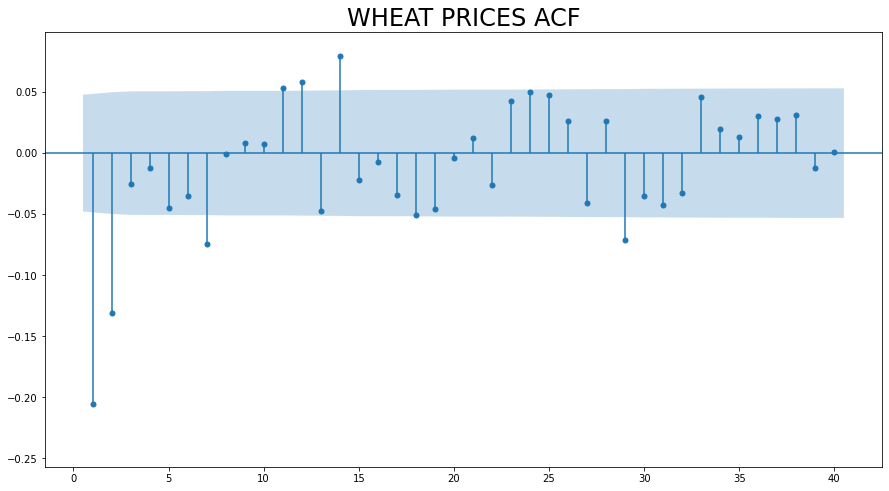

In [129]:
plot_acf(d_wheat,lags=40,zero=False,auto_ylims=True)
plt.title("WHEAT PRICES ACF",size=24)
plt.show()

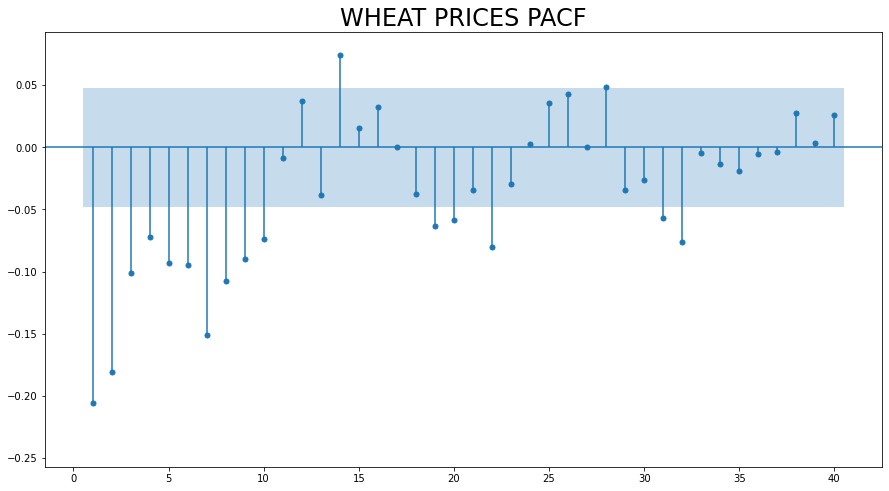

In [130]:
plot_pacf(d_wheat,lags=40,zero=False,auto_ylims=True)
plt.title("WHEAT PRICES PACF",size=24)
plt.show()

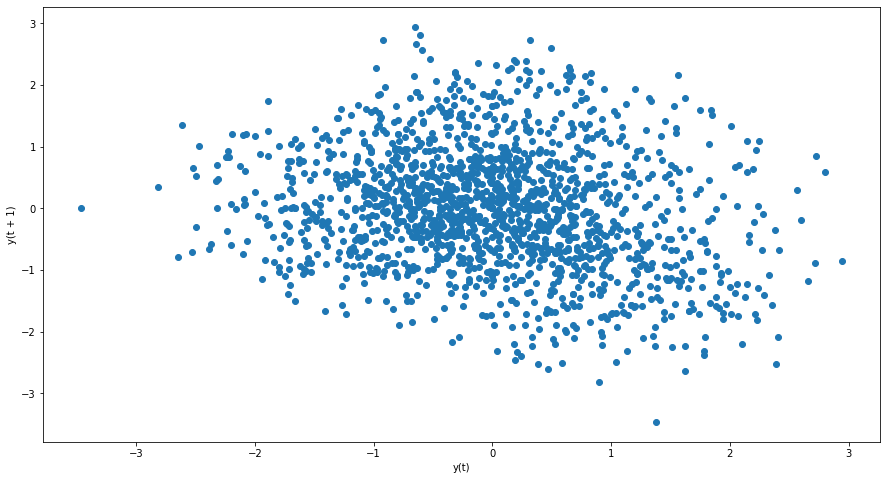

In [131]:
lag_plot(d_wheat);

<div class="alert alert-block alert-success">
<h1 style="color:green;font-size:40px;">RESULT</h1>      
</div>

<div class="alert alert-block alert-info">
<ul>
  <li>When the data sets and plots are examined, they look stationary. Although it is observed that volatility increases from time to time, it is known why every anomaly occurs.</li>
  <li>When examining with seasonal decompose, some seasonality is seen, but it is observed that there is no trend and the data is gathered around the mean and standard deviation.</li>
  <li>With the Dickey-Fuller Test, it was observed that all 3 time series were stationary.</li>
  <li>Sharp cutoff in PACFs and ACF decays slowly indicates stationary</li>
  <li>In conjunction with Granger Causality Tests and in the correlation table, it is observed that 3 time series are associated with certain lags.</li>
  <li>I wanted to increase stationarity because I saw some seasonality in plots as well as seasonal decompose and The Hodrick-Prescott Filter methods and there are outliers.
As a result, I saw that the stationarity increased after the procedures and the residuals were randomly distributed.</li>
</ul>
</div>